https://keras.io/examples/timeseries/timeseries_traffic_forecasting/

https://github.com/PacktPublishing/Hands-On-Graph-Neural-Networks-Using-Python/blob/main/Chapter15/chapter15.ipynb

https://paperswithcode.com/dataset/pemsd7

In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install torchmetrics
!pip install -q torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q torch-geometric-temporal==0.54.0

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

2.1.0+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 45.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 932.1/932.1 kB 86.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 844.3 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 52.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour 

In [2]:
import os
os.chdir('/content/drive/MyDrive/Colab_Notebooks/GNN')

In [3]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
url = "https://github.com/VeritasYin/STGCN_IJCAI-18/raw/master/dataset/PeMSD7_Full.zip"
#url = 'https://github.com/VeritasYin/STGCN_IJCAI-18/raw/master/data_loader/PeMSD7_Full.zip'
with urlopen(url) as zurl:
    with ZipFile(BytesIO(zurl.read())) as zfile:
        zfile.extractall('.')

Text(0, 0.5, 'Traffic speed')

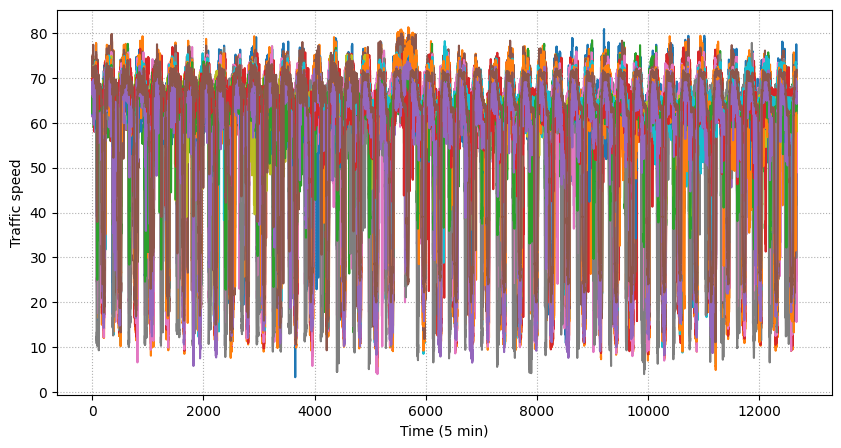

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

speeds = pd.read_csv('PeMSD7_V_228.csv', names=range(0,228))
distances = pd.read_csv('PeMSD7_W_228.csv', names=range(0,228))

# To be able to train with CPU let´s reduce the dataset
sample_routes = [
    0,
    1,
    4,
    7,
    8,
    11,
    15,
    108,
    109,
    114,
    115,
    118,
    120,
    123,
    124,
    126,
    127,
    129,
    130,
    132,
    133,
    136,
    139,
    144,
    147,
    216,
]
distances = distances.iloc[sample_routes, sample_routes]
speeds = speeds.iloc[:, sample_routes]

plt.figure(figsize=(10,5), dpi=100)
plt.plot(speeds)
plt.grid(linestyle=':')
plt.xlabel('Time (5 min)')
plt.ylabel('Traffic speed')

Text(0, 0.5, 'Traffic speed')

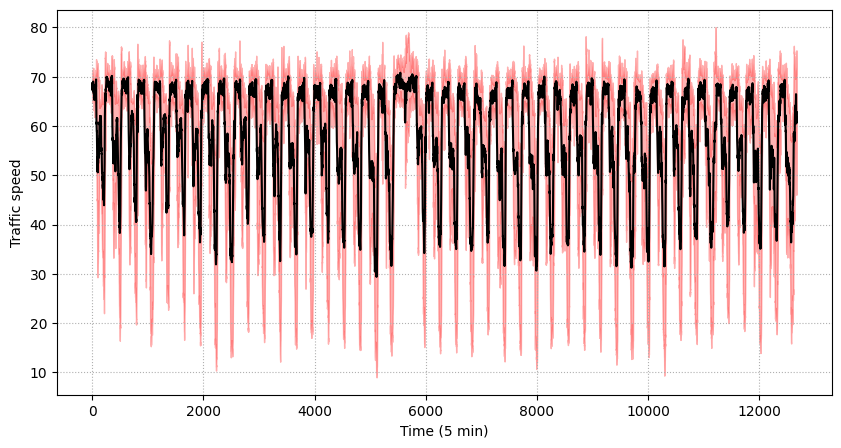

In [6]:
# Plot mean/std traffic speed
mean = speeds.mean(axis=1)
std = speeds.std(axis=1)

plt.figure(figsize=(10,5), dpi=100)
plt.plot(mean, 'k-')
plt.grid(linestyle=':')
plt.fill_between(mean.index, mean-std, mean+std, color='r', alpha=0.3)
plt.xlabel('Time (5 min)')
plt.ylabel('Traffic speed')

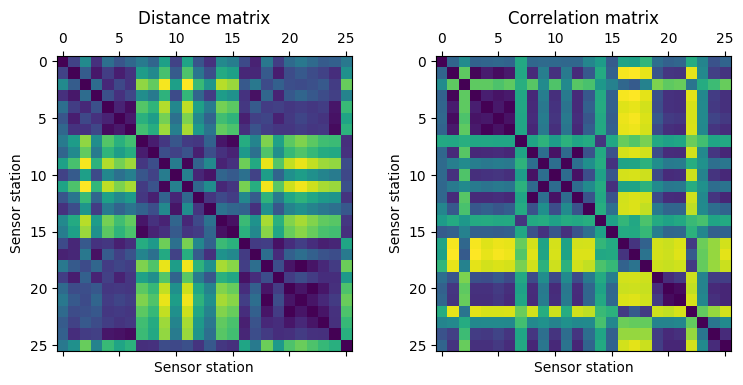

In [7]:
# We can also visualize the correlation between the timeseries in different routes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))
fig.tight_layout(pad=3.0)
ax1.matshow(distances)
ax1.set_xlabel("Sensor station")
ax1.set_ylabel("Sensor station")
ax1.title.set_text("Distance matrix")

ax2.matshow(-np.corrcoef(speeds.T))
ax2.set_xlabel("Sensor station")
ax2.set_ylabel("Sensor station")
ax2.title.set_text("Correlation matrix")

# Processing the dataset

Transforming a tabular dataset into a temporal graph.
We must connect the different stations in a meaningfull way

In [8]:
def compute_adj(distances, sigma2=0.1, epsilon=0.5):
    d = distances.to_numpy() / 10000.
    d2 = d * d
    n = distances.shape[0]
    w_mask = np.ones([n, n]) - np.identity(n)
    return np.exp(-d2 / sigma2) * (np.exp(-d2 / sigma2) >= epsilon) * w_mask

adj = compute_adj(distances)

Text(0, 0.5, 'Sensor station')

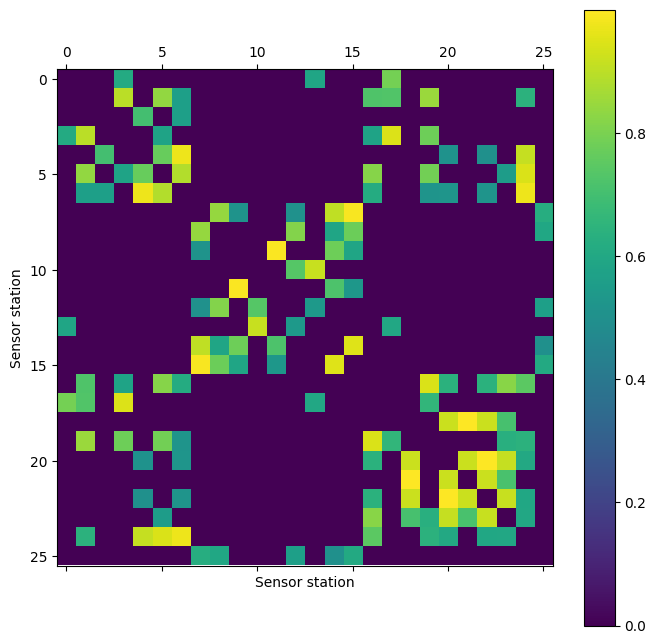

In [9]:
plt.figure(figsize=(8, 8))
cax = plt.matshow(adj, False)
plt.colorbar(cax)
plt.xlabel("Sensor station")
plt.ylabel("Sensor station")

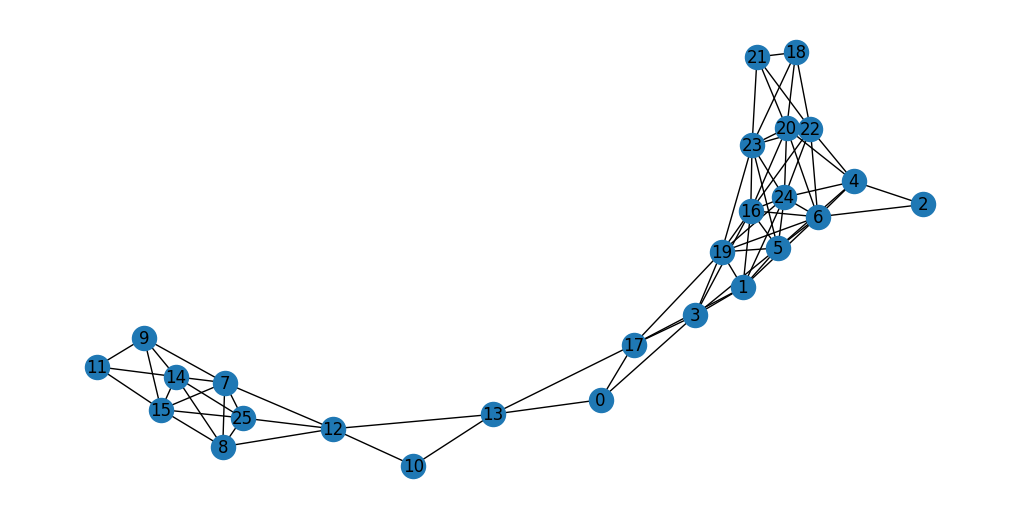

In [10]:
import matplotlib.pyplot as plt
import networkx as nx

def plot_graph(adj):
    plt.figure(figsize=(10,5))
    rows, cols = np.where(adj > 0)
    edges = zip(rows.tolist(), cols.tolist())
    G = nx.Graph()
    G.add_edges_from(edges)
    nx.draw(G, with_labels=True)
    plt.show()

plot_graph(adj)

In [11]:
# Apply z-score
def zscore(x, mean, std):
    return (x - mean) / std

speeds_norm = zscore(speeds, speeds.mean(axis=0), speeds.std(axis=0))

# Create dataset
# Predict traffic speed in 4 hours
lags = 24
horizon = 48
xs = []
ys = []
for i in range(lags, speeds_norm.shape[0]-horizon):
    xs.append(speeds_norm.to_numpy()[i-lags:i].T)
    ys.append(speeds_norm.to_numpy()[i+horizon-1])

# Convert adjacency matrix to edge_index (COO format)
edge_index = (np.array(adj) > 0).nonzero()
edge_index

(array([ 0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  2,  2,  3,  3,  3,  3,  3,
         3,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,
         8,  9,  9,  9,  9, 10, 10, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13,
        13, 13, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 16, 16, 16,
        16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 18, 18, 18, 18, 19, 19,
        19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 20, 20, 21, 21, 21,
        21, 22, 22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 23, 23, 23,
        24, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25]),
 array([ 3, 13, 17,  3,  5,  6, 16, 17, 19, 24,  4,  6,  0,  1,  5, 16, 17,
        19,  2,  5,  6, 20, 22, 24,  1,  3,  4,  6, 16, 19, 23, 24,  1,  2,
         4,  5, 16, 19, 20, 22, 24,  8,  9, 12, 14, 15, 25,  7, 12, 14, 15,
        25,  7, 11, 14, 15, 12, 13,  9, 14, 15,  7,  8, 10, 13, 25,  0, 10,
        12, 17,  7,  8

In [12]:
from torch_geometric_temporal.signal import StaticGraphTemporalSignal
# Create temporal graph
dataset = StaticGraphTemporalSignal(edge_index, adj[adj > 0], xs, ys)
dataset[0]

/usr/local/lib/python3.10/dist-packages/torch_geometric_temporal/signal/static_graph_temporal_signal.py:66: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  return torch.LongTensor(self.edge_index)


Data(x=[26, 24], edge_index=[2, 150], edge_attr=[150], y=[26])

In [13]:
from torch_geometric_temporal.signal import temporal_signal_split

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

In [14]:
from torch_geometric_temporal.nn.recurrent import A3TGCN


class TemporalGNN(torch.nn.Module):
    def __init__(self, dim_in, periods):
        super().__init__()
        self.tgnn = A3TGCN(in_channels=dim_in, out_channels=32, periods=periods)
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index, edge_attr):
        h = self.tgnn(x, edge_index, edge_attr).relu()
        h = self.linear(h)
        return h

model = TemporalGNN(lags, 1).to('cpu')
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
model.train()
print(model)

# Training
for epoch in range(30):
    loss = 0
    step = 0
    for i, snapshot in enumerate(train_dataset):
        y_pred = model(snapshot.x.unsqueeze(2), snapshot.edge_index, snapshot.edge_attr)
        loss += torch.mean((y_pred-snapshot.y)**2)
        step += 1
    loss = loss / (step + 1)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if epoch % 2 == 0:
        print(f"Epoch {epoch:>2} | Train MSE: {loss:.4f}")

TemporalGNN(
  (tgnn): A3TGCN(
    (_base_tgcn): TGCN(
      (conv_z): GCNConv(24, 32)
      (linear_z): Linear(in_features=64, out_features=32, bias=True)
      (conv_r): GCNConv(24, 32)
      (linear_r): Linear(in_features=64, out_features=32, bias=True)
      (conv_h): GCNConv(24, 32)
      (linear_h): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (linear): Linear(in_features=32, out_features=1, bias=True)
)
Epoch  0 | Train MSE: 1.0132
Epoch  2 | Train MSE: 0.9723
Epoch  4 | Train MSE: 0.9540
Epoch  6 | Train MSE: 0.9405
Epoch  8 | Train MSE: 0.9328
Epoch 10 | Train MSE: 0.9248
Epoch 12 | Train MSE: 0.9127
Epoch 14 | Train MSE: 0.9035
Epoch 16 | Train MSE: 0.8959
Epoch 18 | Train MSE: 0.8857
Epoch 20 | Train MSE: 0.8750
Epoch 22 | Train MSE: 0.8678
Epoch 24 | Train MSE: 0.8598
Epoch 26 | Train MSE: 0.8529
Epoch 28 | Train MSE: 0.8479


In [15]:
def inverse_zscore(x, mean, std):
    return x * std + mean

y_test = []
for snapshot in test_dataset:
    y_hat = snapshot.y.numpy()
    y_hat = inverse_zscore(y_hat, speeds.mean(axis=0), speeds.std(axis=0))
    y_test = np.append(y_test, y_hat)

gnn_pred = []
model.eval()
for snapshot in test_dataset:
    snapshot = snapshot
    y_hat = model(snapshot.x.unsqueeze(2), snapshot.edge_index, snapshot.edge_weight).squeeze().detach().numpy()
    y_hat = inverse_zscore(y_hat, speeds.mean(axis=0), speeds.std(axis=0))
    gnn_pred = np.append(gnn_pred, y_hat)

In [17]:
def MAE(real, pred):
    return np.mean(np.abs(pred - real))

def RMSE(real, pred):
    return np.sqrt(np.mean((pred - real) ** 2))

def MAPE(real, pred):
    return np.mean(np.abs(pred - real) / (real + 1e-5))

print(f'GNN MAE  = {MAE(gnn_pred, y_test):.4f}')
print(f'GNN RMSE = {RMSE(gnn_pred, y_test):.4f}')
print(f'GNN MAPE = {MAPE(gnn_pred, y_test):.4f}')

GNN MAE  = 10.0424
GNN RMSE = 13.6563
GNN MAPE = 0.1912


In [18]:
# Random Walk Baseline

rw_pred = []
for snapshot in test_dataset:
    y_hat = snapshot.x[:,-1].squeeze().detach().numpy()
    y_hat = inverse_zscore(y_hat, speeds.mean(axis=0), speeds.std(axis=0))
    rw_pred = np.append(rw_pred, y_hat)

print(f'RW MAE  = {MAE(rw_pred, y_test):.4f}')
print(f'RW RMSE = {RMSE(rw_pred, y_test):.4f}')
print(f'RW MAPE = {MAPE(rw_pred, y_test):.4f}')

# HIstorical Average

ha_pred = []
for i in range(lags, speeds_norm.shape[0]-horizon):
    y_hat = speeds_norm.to_numpy()[:i].T.mean(axis=1)
    y_hat = inverse_zscore(y_hat, speeds.mean(axis=0), speeds.std(axis=0))
    ha_pred.append(y_hat)
ha_pred = np.array(ha_pred).flatten()[-len(y_test):]

print(f'HA MAE  = {MAE(ha_pred, y_test):.4f}')
print(f'HA RMSE = {RMSE(ha_pred, y_test):.4f}')
print(f'HA MAPE = {MAPE(ha_pred, y_test):.4f}')

RW MAE  = 13.0997
RW RMSE = 20.3596
RW MAPE = 0.3895
HA MAE  = 11.5457
HA RMSE = 15.4992
HA MAPE = 0.2078


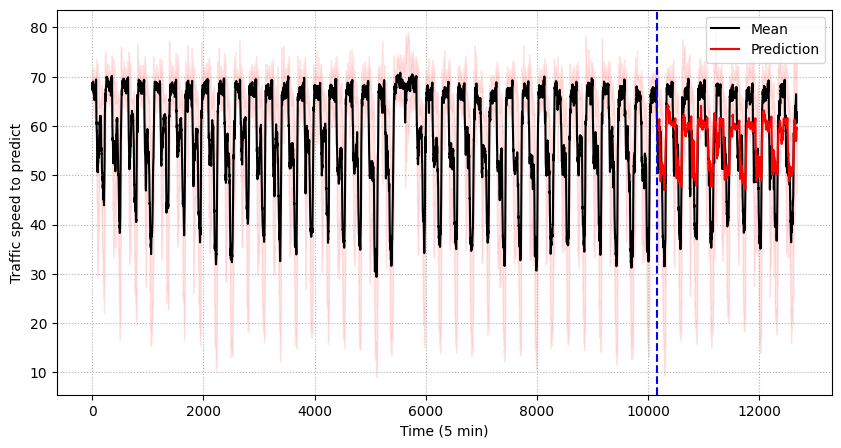

In [19]:
y_preds = [inverse_zscore(model(snapshot.x.unsqueeze(2), snapshot.edge_index, snapshot.edge_weight).squeeze().detach().numpy(), speeds.mean(axis=0), speeds.std(axis=0)).mean() for snapshot in test_dataset]

mean = speeds.mean(axis=1)
std = speeds.std(axis=1)

plt.figure(figsize=(10,5))
plt.plot(np.array(mean), 'k-', label='Mean')
plt.plot(range(len(speeds)-len(y_preds), len(speeds)), y_preds, 'r-', label='Prediction')
plt.grid(linestyle=':')
plt.fill_between(mean.index, mean-std, mean+std, color='r', alpha=0.1)
plt.axvline(x=len(speeds)-len(y_preds), color='b', linestyle='--')
plt.xlabel('Time (5 min)')
plt.ylabel('Traffic speed to predict')
plt.legend(loc='upper right')